# Create an end to end machine learning workflow using Amazon Athena
Importing and transforming data can be one of the most challenging tasks in a machine learning workflow. We provide you with a Jupyter notebook that demonstrates a cost-effective strategy for an extract, transform, and load (ETL) workflow. Using Amazon Simple Storage Service (Amazon S3) and Amazon Athena, you learn how to query and transform data from a Jupyter notebook. Amazon S3 is an object storage service that allows you to store data and machine learning artifacts. Amazon Athena enables you to interactively query the data stored in those buckets, saving each query as a CSV file in an Amazon S3 location.

The tutorial imports 29 CSV files for the 2019 NYC taxi dataset from multiple Amazon S3 locations. The goal is to predict the fare amount for each ride. From those 29 files, the notebook creates a single ride fare dataset and a single ride info dataset with deduplicated values. We join the deduplicated datasets into a single dataset.

Amazon Athena stores the query results as a CSV file in the specified location. This CSV file is provided to a SageMaker Processing Job to split the data into training, validation, and test sets. While data can be split using queries, a processing job ensures that the data is in a format that's parseable by the XGBoost algorithm.

__Important__

The notebook must be run in the us-east-1 AWS Region. You also need your own Amazon S3 bucket and a database within Amazon Athena. You won't be able to access the data used in the tutorial otherwise.

For information about creating a bucket, see [Creating a bucket](https://docs.aws.amazon.com/AmazonS3/latest/userguide/create-bucket-overview.html). For information about creating a database, see [Create a database](https://docs.aws.amazon.com/athena/latest/ug/getting-started.html#step-1-create-a-database).

## Code overview

The following code uses the boto3 client to set up an Athena client within the us-east-1 AWS Region. It defines the run_athena_query function that runs queries and checks their status. Afterwards, it uses the function to create the ride fare and ride info table in Amazon Athena using all the CSV files from the year 2019.

The code creates a separate ride fare and ride info table with all of the duplicate values removed. Amazon Athena saves the query results of the select statements as a CSV string. The get_query_results functions saves the CSV string as a CSV file. We use the function to read the results of our test queries into the notebook as pandas dataframes and verify that we're able to get our data successfully. 

We join the deduplicated tables into a single dataset that we use for our exploratory data analysis. We perform our exploratory data analysis and run a query to select the final set of features we're using for the analysis. We run the SageMaker processing job using the processing-file.py file. Afterwards, we define our model, train our model, and evaluate it on a test set of 20 samples.

In [7]:
# Import required libraries
import time
import boto3

def run_athena_query(query_string, database_name, output_location):
    """
    Function to execute an Athena query and wait for its completion.

    Args:
        query_string (str): The SQL query to be executed.
        database_name (str): The name of the Athena database.
        output_location (str): The S3 location where the query results will be stored.

    Returns:
        str: The query execution ID.
    """
    # Create an Athena client
    athena_client = boto3.client('athena', region_name='us-east-1')

    # Start the query execution
    response = athena_client.start_query_execution(
        QueryString=query_string,
        QueryExecutionContext={'Database': database_name},
        ResultConfiguration={'OutputLocation': output_location}
    )

    query_execution_id = response['QueryExecutionId']
    print(f"Query execution ID: {query_execution_id}")

    while True:
        # Check the query execution status
        query_status = athena_client.get_query_execution(QueryExecutionId=query_execution_id)
        state = query_status['QueryExecution']['Status']['State']

        if state == 'SUCCEEDED':
            print("Query executed successfully.")
            break
        elif state == 'FAILED':
            print(f"Query failed with error: {query_status['QueryExecution']['Status']['StateChangeReason']}")
            break
        else:
            print(f"Query is currently in {state} state. Waiting for completion...")
            time.sleep(5)  # Wait for 5 seconds before checking again

    return query_execution_id

# SQL query to create the 'ride_fare' table
create_ride_fare_table = """
CREATE EXTERNAL TABLE `ride_fare` (
  `ride_id` bigint, 
  `payment_type` smallint, 
  `fare_amount` float, 
  `extra` float, 
  `mta_tax` float, 
  `tip_amount` float, 
  `tolls_amount` float, 
  `total_amount` float
)
ROW FORMAT DELIMITED 
  FIELDS TERMINATED BY ',' 
  LINES TERMINATED BY '\n' 
STORED AS INPUTFORMAT 
  'org.apache.hadoop.mapred.TextInputFormat' 
OUTPUTFORMAT 
  'org.apache.hadoop.hive.ql.io.HiveIgnoreKeyTextOutputFormat'
LOCATION
  's3://dsoaws/nyc-taxi-orig-cleaned-split-csv-with-header-per-year-multiple-files/ride-fare/year=2019'
TBLPROPERTIES (
  'skip.header.line.count'='1', 
  'transient_lastDdlTime'='1716908234'
);
"""

# Athena database name
database = 'database_name'

# S3 location for query results
s3_output_location = 's3://example-s3-bucket/example-s3-prefix'

# Execute the query to create the 'ride_fare' table
run_athena_query(create_ride_fare_table, database, s3_output_location)

Query execution ID: cb779f49-17e5-49fd-91f9-0fbbf62cb9bb
Query is currently in QUEUED state. Waiting for completion...
Query executed successfully.


'cb779f49-17e5-49fd-91f9-0fbbf62cb9bb'

In [12]:
# SQL query to create a new table with duplicates removed
remove_duplicates_from_ride_fare = """
CREATE TABLE ride_fare_deduped
AS
SELECT DISTINCT *
FROM ride_fare
"""

# Run the preceding query
run_athena_query(remove_duplicates_from_ride_fare, database, s3_output_location)

Query execution ID: e07f4538-b44b-4dc8-923d-6758a4e99913
Query is currently in QUEUED state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query executed successfully.


'e07f4538-b44b-4dc8-923d-6758a4e99913'

In [14]:
# SQL query to create the ride_info table
create_ride_info_table_query = """
CREATE EXTERNAL TABLE `ride_info` (
  `ride_id` bigint, 
  `vendor_id` smallint, 
  `passenger_count` smallint, 
  `pickup_at` string, 
  `dropoff_at` string, 
  `trip_distance` float, 
  `rate_code_id` int, 
  `store_and_fwd_flag` string
)
ROW FORMAT DELIMITED 
  FIELDS TERMINATED BY ',' 
  LINES TERMINATED BY '\n' 
STORED AS INPUTFORMAT 
  'org.apache.hadoop.mapred.TextInputFormat' 
OUTPUTFORMAT 
  'org.apache.hadoop.hive.ql.io.HiveIgnoreKeyTextOutputFormat'
LOCATION
  's3://dsoaws/nyc-taxi-orig-cleaned-split-csv-with-header-per-year-multiple-files/ride-info/year=2019'
TBLPROPERTIES (
  'skip.header.line.count'='1', 
  'transient_lastDdlTime'='1716907328'
);
"""

# Run the query to create the ride_info table
run_athena_query(create_ride_info_table_query, database, s3_output_location)

Query execution ID: d8128d6d-c3d7-4c44-99ed-b533f69c3cfa
Query is currently in QUEUED state. Waiting for completion...
Query executed successfully.


'd8128d6d-c3d7-4c44-99ed-b533f69c3cfa'

In [15]:
# SQL query to create table with duplicates removed
remove_duplicates_from_ride_info = """
CREATE TABLE ride_info_deduped
AS
SELECT DISTINCT *
FROM ride_info
"""

# Run the query to create the table with the duplicates removed
run_athena_query(remove_duplicates_from_ride_info, database, s3_output_location)

Query execution ID: 9f4f8ff3-3c76-4ff4-a848-3d834e848cf7
Query is currently in QUEUED state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query executed successfully.


'9f4f8ff3-3c76-4ff4-a848-3d834e848cf7'

In [16]:
test_ride_info_query = '''
SELECT * FROM ride_info_deduped limit 10
'''

run_athena_query(test_ride_info_query, database, s3_output_location)

Query execution ID: 0f66a43e-cde0-4361-a050-09a2616ffefa
Query is currently in QUEUED state. Waiting for completion...
Query executed successfully.


'0f66a43e-cde0-4361-a050-09a2616ffefa'

In [21]:
test_ride_fare_query = '''
SELECT * FROM ride_fare_deduped limit 10
'''

run_athena_query(test_ride_fare_query, database, s3_output_location)

Query execution ID: 1d0f08ba-c579-4ff1-8188-4a7b87043d07
Query is currently in QUEUED state. Waiting for completion...
Query executed successfully.


'1d0f08ba-c579-4ff1-8188-4a7b87043d07'

In [18]:
import io
def get_query_results(query_execution_id):
    """

    Function to retrieve the results of an Athena query execution.


    Args:

        query_execution_id (str): The ID of the query execution.


    Returns:

        io.StringIO: A file-like object containing the query results in CSV format.

    """
    athena_client = boto3.client('athena', region_name='us-east-1')
    s3 = boto3.client('s3')

    # Get the query execution details
    query_execution = athena_client.get_query_execution(QueryExecutionId=query_execution_id)
    s3_location = query_execution['QueryExecution']['ResultConfiguration']['OutputLocation']

    # Extract bucket and key from S3 output location
    bucket_name, key = s3_location.split('/', 2)[2].split('/', 1)

    # Get the CSV file location
    obj = s3.get_object(Bucket=bucket_name, Key=key)
    csv_data = obj['Body'].read().decode('utf-8')
    csv_buffer = io.StringIO(csv_data)

    return csv_buffer

In [19]:
import pandas as pd
# Provide the query execution id of the test_ride_info query to get the query results
ride_info_sample_1 = get_query_results('0f66a43e-cde0-4361-a050-09a2616ffefa')

df_ride_info_sample_1 = pd.read_csv(ride_info_sample_1)

df_ride_info_sample_1.head()

,ride_id,vendor_id,passenger_count,pickup_at,dropoff_at,trip_distance,rate_code_id,store_and_fwd_flag
0,1005024574809,1,1,2019-05-15T12:11:17.000Z,2019-05-15T12:48:59.000Z,3.40,1,N
1,944895157463,2,2,2019-06-18T22:11:43.000Z,2019-06-18T22:29:46.000Z,1.92,1,N
2,944895157471,1,2,2019-06-18T22:29:47.000Z,2019-06-18T22:37:08.000Z,1.00,1,N
3,1005024574929,2,1,2019-05-15T12:26:17.000Z,2019-05-15T12:33:01.000Z,0.95,1,N
4,1005024574951,2,2,2019-05-15T12:51:35.000Z,2019-05-15T13:30:12.000Z,2.65,1,N


In [22]:
# Provide the query execution id of the test_ride_fare query to get the query results

ride_fare_sample_1 = get_query_results('1d0f08ba-c579-4ff1-8188-4a7b87043d07')

df_ride_fare_sample_1 = pd.read_csv(ride_fare_sample_1)

df_ride_fare_sample_1.head()

,ride_id,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,total_amount
0,60130304733,1,5.0,2.5,0.5,2.05,0.00,10.35
1,1391571259067,1,16.5,1.0,0.5,4.16,0.00,24.96
2,1391571259101,2,8.0,1.0,0.5,0.00,0.00,12.30
3,60130304799,1,6.5,0.0,0.5,1.96,0.00,11.76
4,60130304800,1,39.5,3.5,0.5,9.90,5.76,59.46


In [23]:
# SQL query to join the tables into a single table containing all the data.
create_ride_joined_deduped = """
CREATE TABLE combined_ride_data_deduped AS
SELECT 
    rfs.ride_id, 
    rfs.payment_type, 
    rfs.fare_amount, 
    rfs.extra, 
    rfs.mta_tax, 
    rfs.tip_amount, 
    rfs.tolls_amount, 
    rfs.total_amount,
    ris.vendor_id, 
    ris.passenger_count, 
    ris.pickup_at, 
    ris.dropoff_at, 
    ris.trip_distance, 
    ris.rate_code_id, 
    ris.store_and_fwd_flag
FROM 
    ride_fare_deduped rfs
JOIN 
    ride_info_deduped ris
ON 
    rfs.ride_id = ris.ride_id;
;
"""

# Run the query to create the ride_data_deduped table
run_athena_query(create_ride_joined_deduped, database, s3_output_location)

Query execution ID: 2ba0fd2b-030f-4e32-8acb-ec0d802b994f
Query is currently in QUEUED state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query executed successfully.


'2ba0fd2b-030f-4e32-8acb-ec0d802b994f'

In [25]:
# SQL query to select all values from the table and create the dataset that we're using for our analysis
ride_combined_full_table_query = """
SELECT * FROM combined_ride_data_deduped
"""

# Run the query to select all values from the combined_ride_data_deduped table
run_athena_query(ride_combined_full_table_query, database, s3_output_location)

Query execution ID: 08185c50-d51f-4a5f-b82f-e9de593c6b9b
Query is currently in QUEUED state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...

'08185c50-d51f-4a5f-b82f-e9de593c6b9b'

In [47]:
# Function to get the Amazon S3 URI location of Amazon Athena select statements
def get_csv_file_location(query_execution_id):
    athena_client = boto3.client('athena', region_name='us-east-1')
    query_execution = athena_client.get_query_execution(QueryExecutionId=query_execution_id)
    s3_location = query_execution['QueryExecution']['ResultConfiguration']['OutputLocation']

    return s3_location

# Provide the 36 character string at the end of the output of the preceding cell as the query.
get_csv_file_location('query-id-from-preceding-cell')

's3://parsa-ux360-burner-account-bucket/08185c50-d51f-4a5f-b82f-e9de593c6b9b.csv'

In [31]:
# Use the S3 URI location returned from the preceding cell to download the dataset and rename it.
!aws s3 cp s3://example-s3-bucket/query-id.csv .
!mv query-id.csv nyc-taxi-whole-dataset.csv

download: s3://parsa-ux360-burner-account-bucket/08185c50-d51f-4a5f-b82f-e9de593c6b9b.csv to ./08185c50-d51f-4a5f-b82f-e9de593c6b9b.csv


In [32]:
sample_nyc_taxi_combined = pd.read_csv('nyc-taxi-whole-dataset.csv', nrows=20000)

In [33]:
print("Dataset shape: ", sample_nyc_taxi_combined.shape)

Dataset shape:  (20000, 15)


In [34]:
df = sample_nyc_taxi_combined

df.head()

,ride_id,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,total_amount,vendor_id,passenger_count,pickup_at,dropoff_at,trip_distance,rate_code_id,store_and_fwd_flag
0,3839702413301,1,29.5,2.5,0.5,7.75,6.12,46.67,1,1,2019-04-19T13:23:59.000Z,2019-04-19T13:45:15.000Z,10.10,1,N
1,51541365988,2,4.0,1.0,0.5,0.00,0.00,8.30,2,2,2019-02-25T17:01:30.000Z,2019-02-25T17:03:53.000Z,0.49,1,N
2,3770983743101,2,7.0,0.5,0.5,0.00,0.00,8.30,2,1,2019-03-30T20:43:40.000Z,2019-03-30T20:52:18.000Z,1.15,1,N
3,3770983743148,2,6.0,0.5,0.5,0.00,0.00,7.30,2,1,2019-03-30T20:15:08.000Z,2019-03-30T20:19:32.000Z,1.12,1,N
4,3839702413585,1,14.5,2.5,0.5,3.55,0.00,21.35,1,1,2019-04-19T13:10:55.000Z,2019-04-19T13:32:34.000Z,1.90,1,N


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ride_id             20000 non-null  int64  
 1   payment_type        20000 non-null  int64  
 2   fare_amount         20000 non-null  float64
 3   extra               20000 non-null  float64
 4   mta_tax             20000 non-null  float64
 5   tip_amount          20000 non-null  float64
 6   tolls_amount        20000 non-null  float64
 7   total_amount        20000 non-null  float64
 8   vendor_id           20000 non-null  int64  
 9   passenger_count     20000 non-null  int64  
 10  pickup_at           20000 non-null  object 
 11  dropoff_at          20000 non-null  object 
 12  trip_distance       20000 non-null  float64
 13  rate_code_id        20000 non-null  int64  
 14  store_and_fwd_flag  20000 non-null  object 
dtypes: float64(7), int64(5), object(3)
memory usage: 2.3+

In [36]:
df.describe()

,ride_id,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,total_amount,vendor_id,passenger_count,trip_distance,rate_code_id
count,2.000000e+04,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000
mean,1.519688e+12,1.286600,12.963254,1.080586,0.495847,2.146389,0.362381,18.521490,1.622900,1.56580,2.945799,1.055550
std,1.068094e+12,0.474312,12.006646,1.240546,0.053405,2.680182,1.585315,14.706571,0.484672,1.21846,3.797848,0.369014
min,5.153977e+10,1.000000,-52.000000,-4.500000,-0.500000,0.000000,0.000000,-57.300000,1.000000,0.00000,0.000000,1.000000
25%,9.534837e+11,1.000000,6.500000,0.000000,0.500000,0.000000,0.000000,10.800000,1.000000,1.00000,0.980000,1.000000
50%,1.322852e+12,1.000000,9.500000,0.500000,0.500000,1.835000,0.000000,14.160000,2.000000,1.00000,1.610000,1.000000
75%,1.417341e+12,2.000000,14.500000,2.500000,0.500000,2.860000,0.000000,20.160000,2.000000,2.00000,3.050000,1.000000
max,3.839703e+12,4.000000,412.230000,7.000000,1.440000,61.500000,26.000000,412.530000,2.000000,8.00000,44.500000,5.000000


In [37]:
df['vendor_id'].value_counts()

vendor_id
2    12458
1     7542
Name: count, dtype: int64

In [38]:
df['passenger_count'].value_counts()

passenger_count
1    14091
2     2931
3      851
5      832
6      485
4      433
0      376
8        1
Name: count, dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

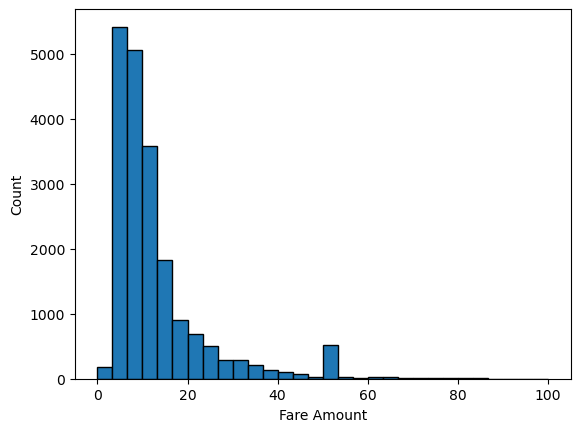

In [39]:
# Plot to find the distribution of ride fare values
import matplotlib.pyplot as plt
plt.hist(df['fare_amount'], edgecolor='black', bins=30, range=(0,100))
plt.xlabel('Fare Amount')
plt.ylabel('Count')
plt.show

In [40]:
df['ride_id'].nunique()

20000

In [41]:
df.drop('store_and_fwd_flag', axis=1, inplace=True)

In [42]:
# We're dropping the time series columns to streamline the analysis.
time_series_columns_to_drop = ['pickup_at','dropoff_at']
df.drop(columns=time_series_columns_to_drop, inplace=True)

In [ ]:
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 22.6 MB/s eta 0:00:00


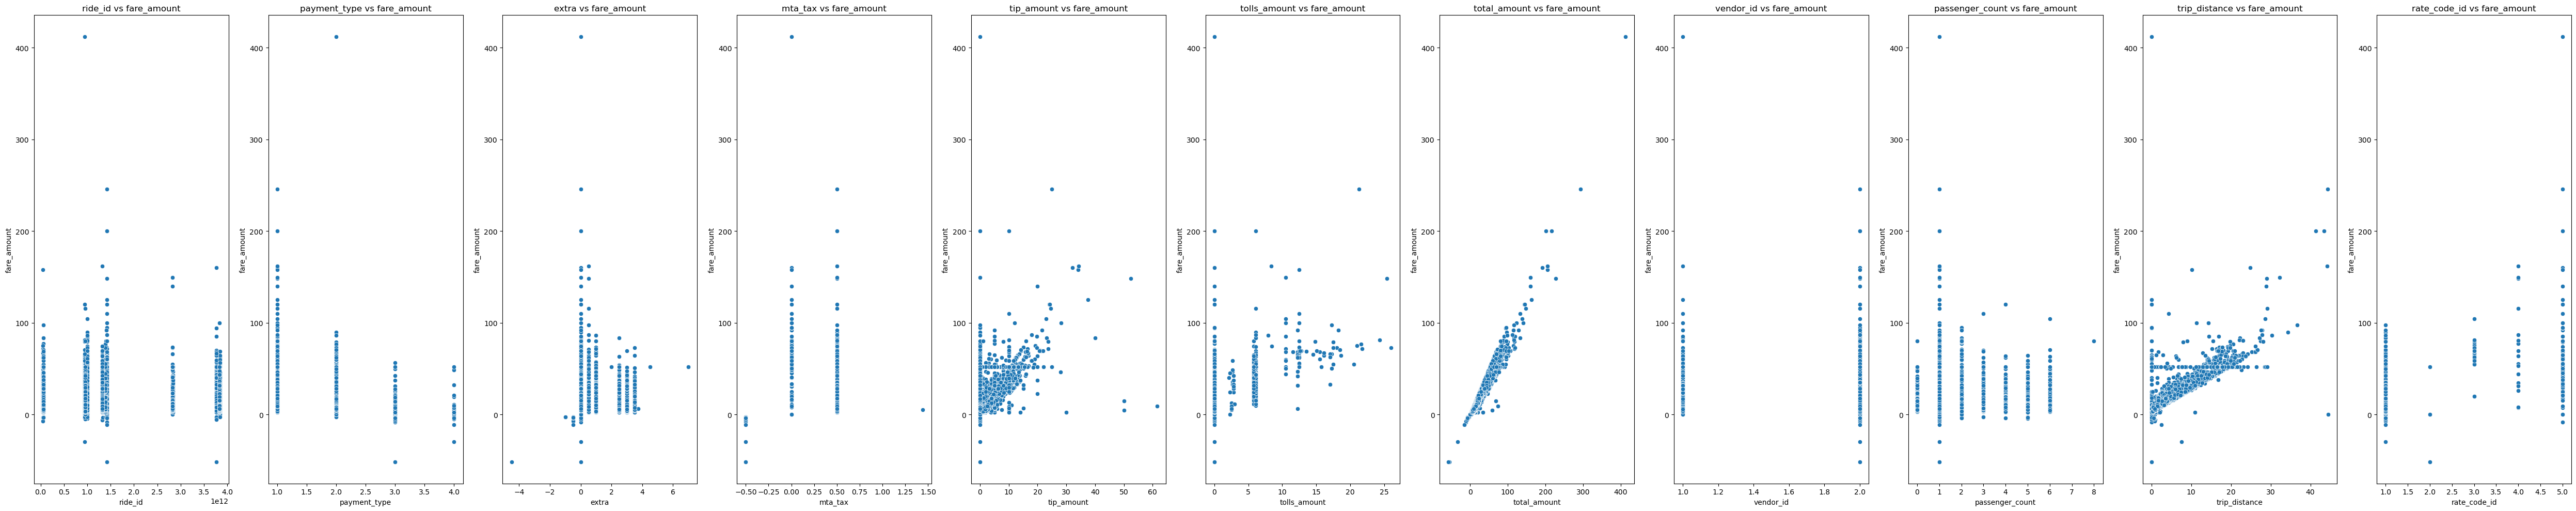

In [43]:
# Create visualizations showing correlations between variables.
import seaborn as sns
target = 'fare_amount'
features = [col for col in df.columns if col != target]

# Create a figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=len(features), figsize=(50, 10))

# Create scatter plots
for i, feature in enumerate(features):
    sns.scatterplot(x=df[feature], y=df[target], ax=axes[i])
    axes[i].set_title(f'{feature} vs {target}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel(target)

plt.tight_layout()
plt.show()

In [44]:
# extra and mta_tax seem weakly correlated
# total_amount is almost perfectly correlated, indicating target leakage.
continuous_features = ['tip_amount', 'tolls_amount', 'extra', 'mta_tax', 'total_amount', 'trip_distance']

for i in continuous_features:
    correlation = df['fare_amount'].corr(df[i])
    print(i, correlation)

tip_amount 0.5490632216119445
tolls_amount 0.6102905023696504
extra -0.014430938533029767
mta_tax -0.15051466243094883
total_amount 0.9774147114602906
trip_distance 0.8802845818094683


In [45]:
# The mta tax and extra have the most variance between the groups
from scipy.stats import f_oneway
# Separate features and target variable
X = df[['payment_type', 'extra', 'mta_tax', 'vendor_id', 'passenger_count']]
y = df['fare_amount']

# Perform one-way ANOVA for each feature
for feature in X.columns:
    groups = [y[X[feature] == group] for group in X[feature].unique()]
    if len(groups) > 1:
        f_statistic, p_value = f_oneway(*groups)
        print(f'Feature: {feature}, F-statistic: {f_statistic:.2f}, p-value: {p_value:.5f}')

Feature: payment_type, F-statistic: 14.30, p-value: 0.00000
Feature: extra, F-statistic: 105.47, p-value: 0.00000
Feature: mta_tax, F-statistic: 630.56, p-value: 0.00000
Feature: vendor_id, F-statistic: 8.74, p-value: 0.00312
Feature: passenger_count, F-statistic: 5.69, p-value: 0.00000


In [46]:
# Dropping passenger count and total_amount from dataset
# Final select statement has tip_amount, tolls_amount, extra, mta_tax, trip_distance
ride_combined_notebook_relevant_features_query = """
SELECT fare_amount, tip_amount, tolls_amount, extra, mta_tax, trip_distance FROM combined_ride_data_deduped
"""

# Run the query to create the dataset that we're using to train our model
run_athena_query(ride_combined_notebook_relevant_features_query, database, s3_output_location)

Query execution ID: e7fbec48-e870-4d00-bb8e-ef1b64851e27
Query is currently in QUEUED state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query is currently in RUNNING state. Waiting for completion...
Query executed successfully.


'e7fbec48-e870-4d00-bb8e-ef1b64851e27'

In [48]:
# For the athena-tutorial-ux360-draft processing script, you're specifying /opt/ml/processing/input/query-id-from-preceding-cell.csv
get_csv_file_location('e7fbec48-e870-4d00-bb8e-ef1b64851e27')

's3://parsa-ux360-burner-account-bucket/e7fbec48-e870-4d00-bb8e-ef1b64851e27.csv'

In [49]:
# Run the processing job to create separate datasets from different files
import sagemaker
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput



# Define the SageMaker execution role
role = sagemaker.get_execution_role()

# Define the SKLearnProcessor
sklearn_processor = SKLearnProcessor(framework_version='0.20.0',
                                     role=role,
                                     instance_type='ml.m5.4xlarge',
                                     instance_count=2)

# Run the processing job
sklearn_processor.run(
    code='athena-tutorial-ux360-draft-processing-file.py',  # Ensure this path is correct
    inputs=[ProcessingInput(
        source='s3://example-s3-bucket/query-id.csv', # use the output of the preceding cell as the source
        destination='/opt/ml/processing/input'
    )],
    outputs=[
        ProcessingOutput(
            source='/opt/ml/processing/output/train',
            destination='s3://example-s3-bucket/output/train'
        ),
        ProcessingOutput(
            source='/opt/ml/processing/output/validation',
            destination='s3://example-s3-bucket/output/validation'
        ),
        ProcessingOutput(
            source='/opt/ml/processing/output/test',
            destination='s3://example-s3-bucket/output/test'
        )
    ]
)


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


INFO:sagemaker:Creating processing-job with name sagemaker-scikit-learn-2024-06-17-14-01-30-730


ResourceLimitExceeded: An error occurred (ResourceLimitExceeded) when calling the CreateProcessingJob operation: The account-level service limit 'ml.m5.4xlarge for processing job usage' is 0 Instances, with current utilization of 0 Instances and a request delta of 1 Instances. Please use AWS Service Quotas to request an increase for this quota. If AWS Service Quotas is not available, contact AWS support to request an increase for this quota.

In [15]:
#Verify that train.csv is in the location that you've specified
!aws s3 ls s3://example-s3-bucket/output/train/

2024-06-13 20:40:41  794188811 fourth-train.csv
2024-06-12 00:14:24  794186734 train.csv


In [16]:
#Verify that val.csv is in the location that you've specified
!aws s3 ls s3://example-s3-bucket/output/validation/

2024-06-13 20:40:41  170181422 fourth-val.csv
2024-06-12 00:14:24  170183095 val.csv


In [2]:
# Specify the input data sources for a training
from sagemaker.session import TrainingInput

bucket = 'example-s3-bucket'

train_input = TrainingInput(
    f"s3://{bucket}/output/train/train.csv", content_type="csv"
)
validation_input = TrainingInput(
    f"s3://{bucket}/output/validation/val.csv", content_type="csv"
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [5]:
# Getting the XGBoost container that's in us-east-1
prefix = "training-output-data"
region = "us-east-1"

from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.session import TrainingInput

# S3 location to store the trained model artifact, so that it can be accessed later
s3_output_location = f's3://{bucket}/{prefix}/xgboost_model'

container = sagemaker.image_uris.retrieve("xgboost", region, "1.2-1")
print(container)

683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.2-1


In [8]:
# Define the model
xgb_model = sagemaker.estimator.Estimator(
    image_uri = container,
    role = role,
    instance_count = 2,
    region = region,
    instance_type = 'ml.m5.4xlarge',
    volume_size = 5, 
    output_path = s3_output_location,
    sagemaker_session = sagemaker.Session(),
    rules = [
        Rule.sagemaker(rule_configs.create_xgboost_report()),
        ProfilerRule.sagemaker(rule_configs.ProfilerReport())
    ]
)

In [9]:
# Set the hyperparameters for the model
xgb_model.set_hyperparameters(
    max_depth = 5,
    eta = 0.2,
    gamma = 4,
    min_child_weight = 6,
    subsample = 0.7,
    objective = "reg:squarederror",
    num_round = 10
)

In [10]:
# Train the model on new data
xgb_model.fit({"train": train_input, "validation": validation_input}, wait=True)

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2024-06-13-21-09-20-115


2024-06-13 21:09:20 Starting - Starting the training job...
2024-06-13 21:09:44 Starting - Preparing the instances for trainingCreateXgboostReport: InProgress
ProfilerReport: InProgress
...
2024-06-13 21:10:08 Downloading - Downloading input data......
2024-06-13 21:11:13 Training - Training image download completed. Training in progress..[2024-06-13 21:11:20.271 ip-10-2-118-110.ec2.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:squarederror to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[2024-06-13 21:11:21.431 ip-1

In [11]:
# Deploy the model so that we can get predictions from it
xgb_predictor = xgb_model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-06-13-21-14-15-341
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2024-06-13-21-14-15-341
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2024-06-13-21-14-15-341


-------!

In [26]:
# Download the test csv file
!aws s3 cp s3://example-s3-bucket/output/test/test.csv .

download: s3://ux360-nyc-taxi-dogfooding/output/test/fourth-test.csv to ./fourth-test.csv


In [23]:
import boto3
import json

# Create a small test dataframe to test predictions
test_df = pd.read_csv('test.csv', nrows=20)
test_df = test_df.drop(test_df.columns[0], axis=1)
test_df.head()

,1,2,3,4,5
0,3.45,0.00,0.0,0.5,1.06
1,0.00,0.00,0.0,0.5,1.00
2,0.00,6.12,1.0,0.5,15.20
3,1.50,0.00,0.0,0.5,1.34
4,0.00,0.00,0.0,0.5,3.86


In [29]:
import boto3
import json
import pandas as pd

# Initialize the SageMaker runtime client
runtime = boto3.client('runtime.sagemaker')

# Define the endpoint name
endpoint_name = 'sagemaker-xgboost-2024-06-13-21-14-15-341'

# Function to make predictions
def get_predictions(data, endpoint_name):
    # Convert the DataFrame to a CSV string and encode it to bytes
    csv_data = data.to_csv(header=False, index=False).encode('utf-8')
    
    response = runtime.invoke_endpoint(
        EndpointName=endpoint_name,
        ContentType='text/csv',
        Body=csv_data
    )
    
    # Read the response body
    response_body = response['Body'].read().decode('utf-8')
    
    try:
        # Try to parse the response as JSON
        result = json.loads(response_body)
    except json.JSONDecodeError:
        # If response is not JSON, just return the raw response
        result = response_body
        
    return result

# Drop the target column from the test dataframe
test_df = test_df.drop(test_df.columns[0], axis=1)

# Get predictions
predictions = get_predictions(test_df, endpoint_name)
print(predictions)

6.515090465545654,6.515090465545654,38.16786193847656,7.602119445800781,13.685721397399902,9.086471557617188,9.086471557617188,6.515090465545654,7.602119445800781,6.515090465545654,10.813796043395996,6.962556838989258,7.602119445800781,9.086471557617188,7.602119445800781,7.602119445800781,27.497194290161133,22.18333625793457,6.962556838989258,8.302289962768555


In [38]:
# Create an array from the single string of predictions
predictions_array = predictions.split(',')

In [39]:
predictions_array

['6.515090465545654',
 '6.515090465545654',
 '38.16786193847656',
 '7.602119445800781',
 '13.685721397399902',
 '9.086471557617188',
 '9.086471557617188',
 '6.515090465545654',
 '7.602119445800781',
 '6.515090465545654',
 '10.813796043395996',
 '6.962556838989258',
 '7.602119445800781',
 '9.086471557617188',
 '7.602119445800781',
 '7.602119445800781',
 '27.497194290161133',
 '22.18333625793457',
 '6.962556838989258',
 '8.302289962768555']

In [32]:
# Get a 20 row sample from the test dataframe
df_with_target_column_values = pd.read_csv('test.csv', nrows=20)
df_with_target_column_values.head()

,0,1,2,3,4,5
0,10.5,3.45,0.00,0.0,0.5,1.06
1,5.0,0.00,0.00,0.0,0.5,1.00
2,52.0,0.00,6.12,1.0,0.5,15.20
3,10.0,1.50,0.00,0.0,0.5,1.34
4,14.0,0.00,0.00,0.0,0.5,3.86


In [48]:
# Convert values from strings to floats
predictions_array = [float(x) for x in predictions_array]

In [49]:
# Create a dataframe to store the predicted versus actual values
comparison_df = pd.DataFrame(predictions_array, columns=['predicted_values'])

In [50]:
comparison_df

,predicted_values
0,6.515090
1,6.515090
2,38.167862
3,7.602119
4,13.685721
5,9.086472
6,9.086472
7,6.515090
8,7.602119
9,6.515090


In [51]:
# Extract the target column from df_with_target_column_values_dataframe
column_to_add = df_with_target_column_values.iloc[:, 0]

# Add the extracted column to df_target with the new header 'actual_values'
comparison_df['actual_values'] = column_to_add

In [52]:
comparison_df

,predicted_values,actual_values
0,6.515090,10.5
1,6.515090,5.0
2,38.167862,52.0
3,7.602119,10.0
4,13.685721,14.0
5,9.086472,10.0
6,9.086472,10.5
7,6.515090,4.0
8,7.602119,7.5
9,6.515090,6.5


In [53]:
# Verify that the datatypes of both columns are floats
comparison_df.dtypes

predicted_values    float64
actual_values       float64
dtype: object

In [54]:
import numpy as np

# Calculate the squared differences between the predicted and actual values
comparison_df['squared_diff'] = (comparison_df['actual_values'] - comparison_df['predicted_values']) ** 2

# Calculate the mean of the squared differences
mean_squared_diff = comparison_df['squared_diff'].mean()

# Take the square root of the mean to get the RMSE
rmse = np.sqrt(mean_squared_diff)

print(f"RMSE: {rmse}")


RMSE: 3.6295376259632905


In [51]:
# Delete the database
delete_database = """
DROP DATABASE mydatabase
"""

run_athena_query(delete_database, database, s3_output_location)

Query execution ID: 9ecad177-c46b-4ec8-b387-20d099fb30de
Query is currently in QUEUED state. Waiting for completion...
Query executed successfully.


'9ecad177-c46b-4ec8-b387-20d099fb30de'

In [ ]:
# Delete the S3 bucket
!aws s3 rb s3://example-s3-bucket --force  

In [ ]:
# Delete the endpoint
xgb_predictor.delete_endpoint()